In [ ]:
import os
import pandas as pd
import requests
import json
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import xgboost as xgboost
import datetime

from sklearn.model_selection import train_test_split #Splitting data for model training
from sklearn.ensemble import RandomForestClassifier #RF
from sklearn.preprocessing import LabelEncoder#Label Encoder
from sklearn.preprocessing import OneHotEncoder#One Hot Encoder
from sklearn.metrics import confusion_matrix#Confusion Matrix
from sklearn.metrics import roc_curve#RoC Curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve#Metrics Functions


In [ ]:
#Define GW for predictions
GW=22

#Fantasy API Calls to pull historic player stats
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
response = requests.get(url)
response = json.loads(response.content)

#Fixtures for upcoming game weeks
fix_url = 'https://fantasy.premierleague.com/api/fixtures?event='+str(GW)
fix_response = requests.get(fix_url)
fix_response = json.loads(fix_response.content)

In [ ]:
def get(url):
    response = requests.get(url)
    return json.loads(response.content)
                      

In [ ]:
players = response['elements']
teams = response['teams']
events = response['events']
#fixtures = fix_response['fixtures']

players_df = pd.DataFrame(players)
teams_df = pd.DataFrame(teams)
events_df = pd.DataFrame(events)
fixtures_df=pd.DataFrame(fix_response)
players_df


,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,ep_this,event_points,first_name,form,id,in_dreamteam,news,news_added,now_cost,photo,points_per_game,second_name,selected_by_percent,special,squad_number,status,team,team_code,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,influence_rank,influence_rank_type,creativity_rank,creativity_rank_type,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,direct_freekicks_order,direct_freekicks_text,penalties_order,penalties_text
0,0.0,0.0,37605,0,0,-3,3,0,3,0.0,0.0,0,Mesut,0.0,1,False,Not included in Arsenal's 25-man Premier Leagu...,2020-10-20T22:30:18.118477Z,67,37605.jpg,0.0,Özil,0.5,False,None,u,1,3,0,3441,0,53856,82,0.0,0.0,Özil,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,650,262,650,262,650,262,650,262,NaN,,NaN,,NaN,
1,0.0,0.0,39476,0,0,-2,2,0,2,0.0,0.0,0,Sokratis,0.0,2,False,Left the club by mutual consent on 20/1,2020-10-21T10:30:18.546407Z,48,39476.jpg,0.0,Papastathopoulos,0.1,False,None,u,1,3,0,10266,0,18978,10,0.0,0.0,Sokratis,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,607,221,598,221,591,219,610,221,NaN,,NaN,,NaN,
2,100.0,100.0,41270,0,0,-1,1,0,2,5.3,4.8,6,David,4.8,3,False,,2020-12-26T18:00:15.638627Z,54,41270.jpg,2.3,Luiz Moreira Marinho,0.8,False,None,a,1,3,28,48380,3827,94758,660,0.9,5.2,David Luiz,839,0,0,3,10,0,0,0,1,0,0,0,143,132.8,30.4,86.0,24.9,256,98,318,106,212,58,289,98,NaN,,4.0,,NaN,
3,75.0,50.0,54694,0,0,-7,7,1,3,3.8,2.2,0,Pierre-Emerick,4.5,4,False,Lack of match fitness - 75% chance of playing,2021-01-23T16:00:22.555453Z,113,54694.jpg,4.2,Aubameyang,6.5,False,None,d,1,3,71,562692,1665,3258367,9740,0.4,6.3,Aubameyang,1514,5,1,7,16,1,0,0,2,0,0,6,202,272.2,226.3,519.0,101.8,133,51,80,57,27,14,42,28,NaN,,NaN,,1.0,
4,100.0,100.0,58822,0,0,-4,4,0,2,5.3,4.8,5,Cédric,4.8,5,False,,2020-09-23T09:00:14.881983Z,46,58822.jpg,5.0,Soares,0.3,False,None,a,1,3,20,14320,5333,37197,495,1.0,4.3,Cédric,275,0,1,2,1,0,0,0,1,0,0,3,71,53.6,65.7,10.0,12.9,354,139,240,58,373,140,349,125,NaN,,NaN,,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,NaN,NaN,448487,0,0,0,0,0,1,-0.5,0.0,0,Andreas,0.0,617,False,,None,40,448487.jpg,0.0,Söndergaard,0.3,False,None,a,20,39,0,25127,1863,6802,841,0.0,0.0,Söndergaard,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,503,53,485,28,460,23,511,53,NaN,,NaN,,NaN,
646,0.0,NaN,209353,0,0,-1,1,0,4,0.0,0.5,0,Patrick,0.5,626,False,Joined Valencia on loan until the end of the s...,2021-01-31T20:00:27.142575Z,59,209353.jpg,1.0,Cutrone,0.0,False,None,u,20,39,2,3443,70,2779,390,0.1,0.3,Cutrone,23,0,0,0,0,0,0,0,0,0,0,0,5,0.0,0.0,4.0,0.2,644,81,645,82,398,61,470,63,NaN,,NaN,,NaN,
647,NaN,NaN,465551,0,0,0,0,0,2,-0.5,0.0,0,Nigel,0.0,629,False,,None,40,465551.jpg,0.0,Lonwijk,0.0,False,None,a,20,39,0,782,61,316,82,0.0,0.0,Lonwijk,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,506,195,488,195,463,181,514,195,NaN,,NaN,,NaN,
648,100.0,100.0,73314,0,0,0,0,0,4,1.0,1.5,2,Willian José,1.5,642,False,,2021-01-26T14:00:25.113370Z,70,73314.jpg,1.5,Da Silva,0.2,False,None,a,20,39,3,14442,4740,2813,1510,0.2,0.4,Willian José,108,0,0,0,1,0,0,0,0,0,0,0,6,13.0,2.2,60.0,7.5,424,48,417,59,261,49,381,51,NaN,,NaN,,NaN,


In [ ]:
#events_df


In [ ]:
#Dataset from Fivethirtyeight providing projected scores for the upcoming game week
spi_data = pd.read_csv('https://projects.fivethirtyeight.com/soccer-api/club/spi_matches_latest.csv')
spi_data=spi_data.loc[(spi_data['season']==2020) & (spi_data['league']=='Barclays Premier League')]
#spi_data

#Team mapping file
team_mapping_spi=pd.read_csv('https://raw.githubusercontent.com/arpitsolanki/FPLBot/main/team_mapping.csv')
#team_mapping_spi

#Add team_ids to the 538 dataset to make it compatible with FPL API datasets
spi_data_name=pd.merge(left=spi_data,right=team_mapping_spi,how='inner',left_on='team1',right_on='team')
spi_data_name=spi_data_name.rename(columns={"id": "team1_id"})

spi_data_name=pd.merge(left=spi_data_name,right=team_mapping_spi,how='inner',left_on='team2',right_on='team')
spi_data_name=spi_data_name.rename(columns={"id": "team2_id"})
#spi_data_name

In [ ]:
players_df

,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,ep_this,event_points,first_name,form,id,in_dreamteam,news,news_added,now_cost,photo,points_per_game,second_name,selected_by_percent,special,squad_number,status,team,team_code,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,influence_rank,influence_rank_type,creativity_rank,creativity_rank_type,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,direct_freekicks_order,direct_freekicks_text,penalties_order,penalties_text
0,0.0,0.0,37605,0,0,-3,3,0,3,0.0,0.0,0,Mesut,0.0,1,False,Not included in Arsenal's 25-man Premier Leagu...,2020-10-20T22:30:18.118477Z,67,37605.jpg,0.0,Özil,0.5,False,None,u,1,3,0,3441,0,53856,82,0.0,0.0,Özil,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,650,262,650,262,650,262,650,262,NaN,,NaN,,NaN,
1,0.0,0.0,39476,0,0,-2,2,0,2,0.0,0.0,0,Sokratis,0.0,2,False,Left the club by mutual consent on 20/1,2020-10-21T10:30:18.546407Z,48,39476.jpg,0.0,Papastathopoulos,0.1,False,None,u,1,3,0,10266,0,18978,10,0.0,0.0,Sokratis,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,607,221,598,221,591,219,610,221,NaN,,NaN,,NaN,
2,100.0,100.0,41270,0,0,-1,1,0,2,5.3,4.8,6,David,4.8,3,False,,2020-12-26T18:00:15.638627Z,54,41270.jpg,2.3,Luiz Moreira Marinho,0.8,False,None,a,1,3,28,48380,3827,94758,660,0.9,5.2,David Luiz,839,0,0,3,10,0,0,0,1,0,0,0,143,132.8,30.4,86.0,24.9,256,98,318,106,212,58,289,98,NaN,,4.0,,NaN,
3,75.0,50.0,54694,0,0,-7,7,1,3,3.8,2.2,0,Pierre-Emerick,4.5,4,False,Lack of match fitness - 75% chance of playing,2021-01-23T16:00:22.555453Z,113,54694.jpg,4.2,Aubameyang,6.5,False,None,d,1,3,71,562692,1665,3258367,9740,0.4,6.3,Aubameyang,1514,5,1,7,16,1,0,0,2,0,0,6,202,272.2,226.3,519.0,101.8,133,51,80,57,27,14,42,28,NaN,,NaN,,1.0,
4,100.0,100.0,58822,0,0,-4,4,0,2,5.3,4.8,5,Cédric,4.8,5,False,,2020-09-23T09:00:14.881983Z,46,58822.jpg,5.0,Soares,0.3,False,None,a,1,3,20,14320,5333,37197,495,1.0,4.3,Cédric,275,0,1,2,1,0,0,0,1,0,0,3,71,53.6,65.7,10.0,12.9,354,139,240,58,373,140,349,125,NaN,,NaN,,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,NaN,NaN,448487,0,0,0,0,0,1,-0.5,0.0,0,Andreas,0.0,617,False,,None,40,448487.jpg,0.0,Söndergaard,0.3,False,None,a,20,39,0,25127,1863,6802,841,0.0,0.0,Söndergaard,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,503,53,485,28,460,23,511,53,NaN,,NaN,,NaN,
646,0.0,NaN,209353,0,0,-1,1,0,4,0.0,0.5,0,Patrick,0.5,626,False,Joined Valencia on loan until the end of the s...,2021-01-31T20:00:27.142575Z,59,209353.jpg,1.0,Cutrone,0.0,False,None,u,20,39,2,3443,70,2779,390,0.1,0.3,Cutrone,23,0,0,0,0,0,0,0,0,0,0,0,5,0.0,0.0,4.0,0.2,644,81,645,82,398,61,470,63,NaN,,NaN,,NaN,
647,NaN,NaN,465551,0,0,0,0,0,2,-0.5,0.0,0,Nigel,0.0,629,False,,None,40,465551.jpg,0.0,Lonwijk,0.0,False,None,a,20,39,0,782,61,316,82,0.0,0.0,Lonwijk,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,506,195,488,195,463,181,514,195,NaN,,NaN,,NaN,
648,100.0,100.0,73314,0,0,0,0,0,4,1.0,1.5,2,Willian José,1.5,642,False,,2021-01-26T14:00:25.113370Z,70,73314.jpg,1.5,Da Silva,0.2,False,None,a,20,39,3,14442,4740,2813,1510,0.2,0.4,Willian José,108,0,0,0,1,0,0,0,0,0,0,0,6,13.0,2.2,60.0,7.5,424,48,417,59,261,49,381,51,NaN,,NaN,,NaN,


In [ ]:
players_df_filtered=players_df[['web_name','element_type','now_cost','selected_by_percent','points_per_game','team','total_points','minutes','goals_scored','assists','clean_sheets','goals_conceded','yellow_cards','red_cards','bonus','chance_of_playing_next_round']]
players_df_filtered=players_df_filtered.loc[players_df_filtered['minutes']>300]
players_df_filtered['now_cost_mil']=players_df_filtered['now_cost']/10
players_df_filtered['ppm']=players_df_filtered['total_points']/players_df_filtered['now_cost_mil']
players_df_filtered.sort_values(by='ppm',ascending=False,inplace=True)


In [ ]:
#players_df_filtered.sort_values(by='total_points',ascending=False)


In [ ]:
teams_df_filtered=teams_df[['id','name','short_name','played','points','position','win','draw','loss']]
teams_df_filtered_join=teams_df[['id','name']]


In [ ]:
fixtures_df_name=pd.merge(left=fixtures_df,right=teams_df_filtered_join,left_on='team_a',right_on='id',how='left')
fixtures_df_name=fixtures_df_name.rename(columns={"name": "away_team"})
fixtures_df_name=pd.merge(left=fixtures_df_name,right=teams_df_filtered_join,left_on='team_h',right_on='id',how='left')
fixtures_df_name=fixtures_df_name.rename(columns={"name": "home_team"})
fixtures_df_name

,code,event,finished,finished_provisional,id_x,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,team_h,team_h_score,stats,team_h_difficulty,team_a_difficulty,pulse_id,id_y,away_team,id,home_team
0,2128501,22,False,False,214,2021-02-02T18:00:00Z,0,False,False,18,None,15,None,[],2,2,59111,18,West Brom,15,Sheffield Utd
1,2128502,22,False,False,215,2021-02-02T18:00:00Z,0,False,False,1,None,20,None,[],3,3,59112,1,Arsenal,20,Wolves
2,2128500,22,False,False,213,2021-02-02T20:15:00Z,0,False,False,16,None,13,None,[],3,4,59110,16,Southampton,13,Man Utd
3,2128504,22,False,False,217,2021-02-02T20:15:00Z,0,False,False,6,None,14,None,[],3,3,59114,6,Crystal Palace,14,Newcastle
4,2128497,22,False,False,210,2021-02-03T18:00:00Z,0,False,False,12,None,4,None,[],4,2,59107,12,Man City,4,Burnley
5,2128498,22,False,False,211,2021-02-03T18:00:00Z,0,False,False,9,None,8,None,[],4,2,59108,9,Leicester,8,Fulham
6,2128499,22,False,False,212,2021-02-03T19:30:00Z,0,False,False,7,None,10,None,[],3,3,59109,7,Everton,10,Leeds
7,2128496,22,False,False,209,2021-02-03T20:15:00Z,0,False,False,19,None,2,None,[],3,3,59106,19,West Ham,2,Aston Villa
8,2128503,22,False,False,216,2021-02-03T20:15:00Z,0,False,False,3,None,11,None,[],2,5,59113,3,Brighton,11,Liverpool
9,2128505,22,False,False,218,2021-02-04T20:00:00Z,0,False,False,5,None,17,None,[],4,4,59115,5,Chelsea,17,Spurs


In [ ]:
df_l=[]
for i in range(GW):
  fix_url = 'https://fantasy.premierleague.com/api/fixtures?event='+str(i+1)
  fix_response = requests.get(fix_url)
  fix_response = json.loads(fix_response.content)
  fixtures_df=pd.DataFrame(fix_response)
  fixtures_df['gw']=i+1
  df_l.append(fixtures_df)
#  print(fix_url)

fixtures_df = pd.concat(df_l, axis=0, ignore_index=True)
fixtures_df_map=fixtures_df[['gw','kickoff_time']].copy()

fixtures_df_map['date']=pd.to_datetime(fixtures_df_map['kickoff_time'], errors='coerce').dt.date

del fixtures_df_map['kickoff_time']
fixtures_df_map=fixtures_df_map.drop_duplicates()
#fixtures_df_map

In [ ]:
fixtures_df_name_cur_gw=fixtures_df_name[['home_team','away_team','id','id_y']]
fixtures_df_name_cur_gw.columns=['home_team','away_team','home_id','away_id']



In [ ]:
spi_data_name_fil=spi_data_name[['team1','team2','team1_id','team2_id','proj_score1','proj_score2']]
spi_data_name_fil.columns=['team1','team2','home_id','away_id','proj_score1','proj_score2']

spi_gw_scores=pd.merge(left=fixtures_df_name_cur_gw,right=spi_data_name_fil,left_on=['home_id','away_id'],right_on=['home_id','away_id'],how='inner')


In [ ]:
players_df_filtered_teams=pd.merge(left=players_df_filtered,right=teams_df_filtered_join,how='inner',left_on='team',right_on='id')
#players_df_filtered_teams

In [ ]:
#Read historical fixtures data

team_list=['understat_Arsenal.csv','understat_Aston_Villa.csv','understat_Brighton.csv','understat_Burnley.csv','understat_Chelsea.csv','understat_Crystal_Palace.csv','understat_Everton.csv','understat_Fulham.csv','understat_Leeds.csv','understat_Leicester.csv','understat_Liverpool.csv','understat_Manchester_City.csv','understat_Manchester_United.csv','understat_Newcastle_United.csv','understat_Sheffield_United.csv','understat_Southampton.csv','understat_Tottenham.csv','understat_West_Bromwich_Albion.csv','understat_West_Ham.csv','understat_Wolverhampton_Wanderers.csv']
static='https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/understat/'
df_l=[]

for i in range(20):
  k=static+team_list[i]
  temp=pd.read_csv(k)
 # print(temp.shape[0])
  temp['team']=team_list[i]
  df_l.append(temp)

team_total_data = pd.concat(df_l, axis=0, ignore_index=True)

#team_total_data
#team_mapping_spi
team_total_data_id=pd.merge(left=team_total_data,right=team_mapping_spi,left_on='team',right_on='team_file_name',how='left')
team_total_data_id

team_total_data_id=team_total_data_id[['team_y','id','pts','date','h_a','xG','xGA','deep','deep_allowed','scored','missed']]
# #team_total_data_id
team_total_data_id['date_new']=pd.to_datetime(team_total_data_id['date'], errors='coerce').dt.date

del team_total_data_id['date']
team_total_data_id['cum_pts']=team_total_data_id.groupby(['team_y'])['pts'].cumsum()

#team_total_data_id

team_total_data_id_means = team_total_data_id.join(team_total_data_id.groupby(['id']).expanding().agg({'xG':'mean','xGA': 'mean', 'deep': 'mean', 'deep_allowed': 'mean','scored':'mean','missed':'mean'})
               .reset_index(level=0, drop=True)
               .add_suffix('_roll'))
team_total_data_id_means=team_total_data_id_means.groupby(['id', 'date_new']).last().reset_index()
team_total_data_id_means=team_total_data_id_means[['id','date_new','xG_roll','xGA_roll','deep_roll','deep_allowed_roll','scored_roll','missed_roll']]
team_total_data_id_means
#Create a league standings table
team_total_data_id=pd.merge(left=team_total_data_id,right=fixtures_df_map,left_on='date_new',right_on='date',how='inner')
team_total_data_id.sort_values(by='cum_pts',inplace=True,ascending=False)
team_total_data_id=team_total_data_id[['cum_pts','gw','id','date_new']]
team_total_data_id["rank"] = team_total_data_id.groupby("gw")["cum_pts"].rank("dense", ascending=False)
team_total_data_id.columns=['cum_pts','gw','id','date_new','rank']
#team_total_data_id

team_total_data_id=pd.merge(left=team_total_data_id,right=team_total_data_id_means,left_on=['id','date_new'],right_on=['id','date_new'],how='inner')
del team_total_data_id['date_new']
team_total_data_id['xG_diff']=team_total_data_id['xG_roll']-team_total_data_id['xGA_roll']
team_total_data_id['deep_diff']=team_total_data_id['deep_roll']/(team_total_data_id['deep_roll']+team_total_data_id['deep_allowed_roll'])
team_total_data_id['scored_diff']=team_total_data_id['scored_roll']/(team_total_data_id['scored_roll']+team_total_data_id['missed_roll'])
team_total_data_id=team_total_data_id[['cum_pts','gw','id','rank','xG_diff','deep_diff','scored_diff']]
team_total_data_id
#team_total_data_id.to_csv('team_total_data_id.csv')
#files.download('team_total_data_id.csv')


,cum_pts,gw,id,rank,xG_diff,deep_diff,scored_diff
0,44,21,12,1.0,1.294208,0.750865,0.740000
1,41,21,13,2.0,0.455679,0.614094,0.578125
2,41,20,12,1.0,1.289870,0.761733,0.734694
3,40,20,13,2.0,0.440155,0.607639,0.578125
4,40,21,11,3.0,0.805659,0.804217,0.641791
...,...,...,...,...,...,...,...
405,0,2,4,3.0,0.536675,0.300000,0.333333
406,0,4,4,8.0,-0.446754,0.510204,0.272727
407,0,2,16,3.0,-0.067990,0.818182,0.250000
408,0,1,18,2.0,-2.602813,0.666667,0.000000


In [ ]:
#Read Gameweek history

#gw_list=['gw1','gw2','gw3','gw4','gw5','gw6','gw7','gw8','gw9','gw10','gw11','gw12','gw13','gw14','gw15']
gw_list=[]
for i in range(GW-1):
  gw_str='gw'+str(i+1)
  gw_list.append(gw_str)
print(gw_list)

static='https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/gws/'
df_l=[]

for i in range(len(gw_list)):
  k=static+gw_list[i]+'.csv'
  temp=pd.read_csv(k)
  temp['gw']=i+1
  df_l.append(temp)
# print(k)

weekly_data = pd.concat(df_l, axis=0, ignore_index=True)
#weekly_data

weekly_data_team=pd.merge(left=weekly_data,right=teams_df_filtered_join,left_on='opponent_team',right_on='id',how='inner')
weekly_data_team=weekly_data_team.rename(columns={"name_y": "opponent_team_name"})

weekly_data_team=pd.merge(left=weekly_data_team,right=teams_df_filtered_join,left_on='team',right_on='name',how='inner')
weekly_data_team=weekly_data_team.rename(columns={"name_x": "player_name",'id_y':'team_id'})
#weekly_data_team


['gw1', 'gw2', 'gw3', 'gw4', 'gw5', 'gw6', 'gw7', 'gw8', 'gw9', 'gw10', 'gw11', 'gw12', 'gw13', 'gw14', 'gw15', 'gw16', 'gw17', 'gw18', 'gw19', 'gw20', 'gw21']


In [ ]:
weekly_data_team.gw.max()

21

In [ ]:
#weekly_data_team.iloc[0,33]
#Add the home and away team columns
weekly_data_team['home_team'] = weekly_data_team['team_id']
weekly_data_team['away_team'] = weekly_data_team['team_id']

weekly_data_team.loc[weekly_data_team['was_home'] == True, 'home_team'] = weekly_data_team.loc[weekly_data_team['was_home'] == True, 'team_id']
weekly_data_team.loc[weekly_data_team['was_home'] == True, 'away_team'] = weekly_data_team.loc[weekly_data_team['was_home'] == True, 'opponent_team']

weekly_data_team.loc[weekly_data_team['was_home'] == False, 'home_team'] = weekly_data_team.loc[weekly_data_team['was_home'] == False, 'opponent_team']
weekly_data_team.loc[weekly_data_team['was_home'] == False, 'away_team'] = weekly_data_team.loc[weekly_data_team['was_home'] == False, 'team_id']
#weekly_data_team

weekly_data_team_spi=pd.merge(left=weekly_data_team,right=spi_data_name_fil,left_on=['home_team','away_team'],right_on=['home_id','away_id'],how='inner')
weekly_data_team_spi

#Weekly data remove players who haven't started yet
zero_min=weekly_data_team_spi.groupby(['player_name',]).agg({'minutes':'sum'}).reset_index()
zero_min=zero_min.loc[zero_min['minutes']==0]
#zero_min
#weekly_data_team_spi.player_name.isin(zero_min['player_name']).sum()

weekly_data_team_spi_zero=weekly_data_team_spi[~(weekly_data_team_spi.player_name.isin(zero_min['player_name']))]
# weekly_data_team_spi_zero['team_id']=0
# weekly_data_team_spi_zero.loc[:,'team_id']=weekly_data_team_spi_zero.loc[weekly_data_team_spi_zero['was_home']=True,'home_team']
#weekly_data_team_spi_zero


In [ ]:
#Most points in a gameweek
gp=weekly_data.groupby(['name','gw']).agg({'total_points':'sum'}).reset_index()
gp.sort_values(by='total_points',ascending=False)


,name,gw,total_points
5866,John Stones,19,27
4677,Jack Grealish,4,24
4391,Heung-Min Son,2,24
7880,Matheus Pereira,19,24
9798,Riyad Mahrez,10,21
...,...,...,...
127,Aboubakar Kamara,6,-2
3399,Erik Pieters,2,-2
7311,Luke Shaw,4,-2
662,Andreas Christensen,2,-3


In [ ]:
#Distribution of points scored by players
gp=weekly_data_team_spi_zero.groupby(['total_points']).size().reset_index(name='counts')
#gp.sort_values(by='counts',ascending=False)

fig=px.bar(gp,x='total_points',y='counts',title='Distribution of points scored in gameweek by players')
fig.show()


In [ ]:
#Points Distribution by Position
weekly_data_team_spi_zero['point_flag']=0

weekly_data_team_spi_zero.loc[weekly_data_team_spi_zero['total_points']>2,'point_flag']=1
#weekly_data_team_spi_zero

gp=weekly_data_team_spi_zero.groupby(['position','point_flag']).size().reset_index(name='counts')
gp

fig = make_subplots(rows=1, cols=4,specs=[[{'type':'domain'}, {'type':'domain'},{'type':'domain'},{'type':'domain'}]],subplot_titles=("GK","DEF","MID","FWD"))

fig.add_trace(go.Pie(labels=gp.loc[gp['position']=='GK','point_flag'], values=gp.loc[gp['position']=='GK','counts'], name="GK"),1, 1)
fig.add_trace(go.Pie(labels=gp.loc[gp['position']=='DEF','point_flag'], values=gp.loc[gp['position']=='DEF','counts'], name="DEF"),1, 2)
fig.add_trace(go.Pie(labels=gp.loc[gp['position']=='MID','point_flag'], values=gp.loc[gp['position']=='MID','counts'], name="MID"),1, 3)
fig.add_trace(go.Pie(labels=gp.loc[gp['position']=='FWD','point_flag'], values=gp.loc[gp['position']=='FWD','counts'], name="FW"),1, 4)

fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Points Distribution by Position")

fig.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#weekly_data_team_spi_zero


In [ ]:
player_summary=weekly_data_team_spi_zero[['player_name','round','team_id','total_points']]
team_gp=player_summary.groupby(['team_id','round']).agg({'total_points':'sum'}).reset_index()
team_gp.columns=['team_id','round','team_total_points']
team_gp

team_gp['team_total_points_cumsum'] = team_gp.groupby(['team_id'])['team_total_points'].cumsum()
team_gp
del team_gp['team_total_points']
# team_player_gp=player_summary.groupby(['team_id','player_name','round']).agg({'total_points':'sum'}).reset_index()
# team_player_gp.columns=['team_id','player_name','round','team_total_points']
# team_player_gp

# from google.colab import files

# team_player_gp.to_csv('team_player_gp.csv')
# files.download('team_player_gp.csv')


In [ ]:
#Feature Engineering
weekly_data_subset=weekly_data_team_spi_zero[['player_name','gw','position','team','round','id_x','team_id','xP','assists','bonus','clean_sheets','goals_scored','goals_conceded','minutes','creativity','ict_index','influence','selected','threat','yellow_cards','red_cards','was_home','home_team','away_team','proj_score1','proj_score2','total_points','point_flag']]
weekly_data_subset=weekly_data_subset.rename(columns={"id_x": "opponent_id"})

#Weekly Cumulative sums for last four weeks
weekly_data_subset.sort_values(by=['player_name','gw'],ascending=True,inplace=True)
gp_cols=weekly_data_subset[['player_name','gw','red_cards','yellow_cards','xP','total_points','bonus','clean_sheets','assists','minutes','influence','creativity','threat','ict_index']]
#gp_cols=gp_cols.loc[gp_cols.gw>=GW-4]
gp_cumsum=gp_cols.groupby(['player_name','gw']).sum().groupby('player_name').cumsum().reset_index()

#Season rolling numbers

#Weekly Mean Sums 
weekly_rolling_means = weekly_data_subset.join(weekly_data_subset.groupby(['player_name']).expanding().agg({'minutes':'mean','influence': 'mean', 'creativity': 'mean', 'threat': 'mean','ict_index':'mean','selected':'mean','total_points':'mean'})
               .reset_index(level=0, drop=True)
               .add_suffix('_roll'))
weekly_rolling_means=weekly_rolling_means.groupby(['round', 'player_name']).last().reset_index()
weekly_rolling_means=weekly_rolling_means[['player_name','gw','influence_roll', 'creativity_roll', 'threat_roll','ict_index_roll','minutes_roll','selected_roll','total_points_roll']]



weekly_data_subset_new=weekly_data_subset[['player_name','gw','position','team','round','team_id','opponent_id','was_home','home_team','away_team','proj_score1','proj_score2','point_flag']].copy()

weekly_data_subset_new['join_key']=0
gw=weekly_data_subset_new['gw']
weekly_data_subset_new.loc[:,'join_key']=gw-1

#Merge cumulative sums
weekly_data_subset_new_agg=pd.merge(left=weekly_data_subset_new,right=weekly_rolling_means,left_on=['player_name','join_key'],right_on=['player_name','gw'],how='inner')

#Merge cumulative means
weekly_data_subset_new_agg=pd.merge(left=weekly_data_subset_new_agg,right=gp_cumsum,left_on=['player_name','join_key'],right_on=['player_name','gw'],how='inner')

#Merge team total ranking stats with home team
weekly_data_subset_new_agg_home=pd.merge(left=weekly_data_subset_new_agg,right=team_total_data_id,left_on=['team_id','join_key'],right_on=['id','gw'])
weekly_data_subset_new_agg_home=weekly_data_subset_new_agg_home.rename(columns={"rank": "team_rank",'cum_pts':'team_pts','xG_diff':'xG_diff_team','scored_diff':'scored_diff_team','deep_diff':'deep_diff_team'})

#Merge team total ranking stats with away team
weekly_data_subset_new_agg_pts=pd.merge(left=weekly_data_subset_new_agg_home,right=team_total_data_id,left_on=['opponent_id','join_key'],right_on=['id','gw'])
weekly_data_subset_new_agg_pts=weekly_data_subset_new_agg_pts.rename(columns={"rank": "opponent_rank",'cum_pts':'opponent_points','xG_diff':'xG_diff_opponent','scored_diff':'scored_diff_opponent','deep_diff':'deep_diff_opponent'})

#Calculate rank and projected score differences for the upcoming fixture
weekly_data_subset_new_agg_pts['rank_diff']=weekly_data_subset_new_agg_pts['team_rank']-weekly_data_subset_new_agg_pts['opponent_rank']
weekly_data_subset_new_agg_pts['proj_score_diff']=weekly_data_subset_new_agg_pts['proj_score1']-weekly_data_subset_new_agg_pts['proj_score2']

#Merge team total ranking stats with away team
weekly_data_subset_new_agg_pts_team=pd.merge(left=weekly_data_subset_new_agg_pts,right=team_gp,left_on=['team_id','join_key'],right_on=['team_id','round'],how='inner')

weekly_data_subset_new_agg_pts_team['percent_team_points']=weekly_data_subset_new_agg_pts_team['total_points']/weekly_data_subset_new_agg_pts_team['team_total_points_cumsum']

# ##del weekly_data_subset_new_agg_pts['gw']
del weekly_data_subset_new_agg_pts_team['gw_y']
del weekly_data_subset_new_agg_pts_team['gw_x']
del weekly_data_subset_new_agg_pts_team['id_x']
del weekly_data_subset_new_agg_pts_team['id_y']
del weekly_data_subset_new_agg_pts_team['join_key']
del weekly_data_subset_new_agg_pts_team['team_id']
del weekly_data_subset_new_agg_pts_team['opponent_id']

weekly_data_subset_new_agg_pts_team

#weekly_data_subset_new_agg_pts_team.to_csv('weekly_data_subset_new_agg_pts_team.csv')
#files.download('weekly_data_subset_new_agg_pts_team.csv')

,player_name,position,team,round_x,was_home,home_team,away_team,proj_score1,proj_score2,point_flag,influence_roll,creativity_roll,threat_roll,ict_index_roll,minutes_roll,selected_roll,total_points_roll,red_cards,yellow_cards,xP,total_points,bonus,clean_sheets,assists,minutes,influence,creativity,threat,ict_index,team_pts,team_rank,xG_diff_team,deep_diff_team,scored_diff_team,opponent_points,gw,opponent_rank,xG_diff_opponent,deep_diff_opponent,scored_diff_opponent,rank_diff,proj_score_diff,round_y,team_total_points_cumsum,percent_team_points
0,Aaron Connolly,FWD,Brighton,2,False,14,3,1.28,1.13,1,1.2,0.30,32.0,3.40,45.0,32205.0,1.0,0,0,0.5,1,0,0,0,45,1.2,0.3,32.0,3.4,0,2.0,0.172190,0.333333,0.25,3,1,1.0,0.797665,0.666667,1.0,1.0,0.15,1,27,0.037037
1,Adam Lallana,MID,Brighton,2,False,14,3,1.28,1.13,0,6.8,27.20,2.0,3.60,44.0,78657.0,1.0,0,0,1.2,1,0,0,0,44,6.8,27.2,2.0,3.6,0,2.0,0.172190,0.333333,0.25,3,1,1.0,0.797665,0.666667,1.0,1.0,0.15,1,27,0.037037
2,Adam Webster,DEF,Brighton,2,False,14,3,1.28,1.13,1,14.8,11.80,1.0,2.80,90.0,187445.0,1.0,0,0,0.6,1,0,0,0,90,14.8,11.8,1.0,2.8,0,2.0,0.172190,0.333333,0.25,3,1,1.0,0.797665,0.666667,1.0,1.0,0.15,1,27,0.037037
3,Alexis Mac Allister,MID,Brighton,2,False,14,3,1.28,1.13,0,0.0,0.00,0.0,0.00,0.0,3939.0,0.0,0,0,0.8,0,0,0,0,0,0.0,0.0,0.0,0.0,0,2.0,0.172190,0.333333,0.25,3,1,1.0,0.797665,0.666667,1.0,1.0,0.15,1,27,0.000000
4,Alireza Jahanbakhsh,MID,Brighton,2,False,14,3,1.28,1.13,0,4.4,0.70,0.0,0.50,11.0,3104.0,1.0,0,0,0.8,1,0,0,0,11,4.4,0.7,0.0,0.5,0,2.0,0.172190,0.333333,0.25,3,1,1.0,0.797665,0.666667,1.0,1.0,0.15,1,27,0.037037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8545,Patrick Bamford,FWD,Leeds,3,False,15,10,1.40,1.05,1,45.2,6.20,24.0,7.55,65.0,489813.0,10.5,0,0,10.6,21,3,0,2,130,90.4,12.4,48.0,15.1,3,2.0,-1.493399,0.233333,0.50,0,2,3.0,-0.309657,0.375000,0.0,-1.0,0.35,2,92,0.228261
8546,Robin Koch,DEF,Leeds,3,False,15,10,1.40,1.05,1,17.9,0.25,19.5,3.80,90.0,36835.0,0.5,0,0,0.6,1,0,0,0,180,35.8,0.5,39.0,7.6,3,2.0,-1.493399,0.233333,0.50,0,2,3.0,-0.309657,0.375000,0.0,-1.0,0.35,2,92,0.010870
8547,Rodrigo Moreno,FWD,Leeds,3,False,15,10,1.40,1.05,0,0.0,0.50,2.0,0.25,36.5,467745.0,1.0,0,0,1.3,2,0,0,0,73,0.0,1.0,4.0,0.5,3,2.0,-1.493399,0.233333,0.50,0,2,3.0,-0.309657,0.375000,0.0,-1.0,0.35,2,92,0.021739
8548,Stuart Dallas,DEF,Leeds,3,False,15,10,1.40,1.05,1,22.2,2.50,3.0,2.80,90.0,307651.0,2.0,0,0,2.1,4,0,0,1,180,44.4,5.0,6.0,5.6,3,2.0,-1.493399,0.233333,0.50,0,2,3.0,-0.309657,0.375000,0.0,-1.0,0.35,2,92,0.043478


In [ ]:
# weekly_data_subset=weekly_data_subset.sort_values(by=['player_name','gw']).reset_index(drop=True)
# #weekly_data_subset

# weekly_rolling_means = weekly_data_subset.join(weekly_data_subset.groupby(['player_name']).expanding().agg({'minutes':'mean','influence': 'mean', 'creativity': 'mean', 'threat': 'mean','ict_index':'mean'})
#                .reset_index(level=0, drop=True)
#                .add_suffix('_roll'))

# weekly_rolling_means=weekly_rolling_means.groupby(['round', 'player_name']).last().reset_index()
# weekly_rolling_means=weekly_rolling_means[['player_name','gw','influence_roll', 'creativity_roll', 'threat_roll','ict_index_roll','minutes_roll']]
# weekly_rolling_means
# # k.to_csv('k.csv')
# # files.download('k.csv')

gp_cumsum

,player_name,gw,red_cards,yellow_cards,xP,total_points,bonus,clean_sheets,assists,minutes,influence,creativity,threat,ict_index
0,Aaron Connolly,1,0,0,0.5,1,0,0,0,45,1.2,0.3,32.0,3.4
1,Aaron Connolly,2,0,0,4.5,9,2,1,0,134,36.0,11.6,55.0,10.3
2,Aaron Connolly,3,0,0,7.2,11,2,1,0,207,36.0,23.7,63.0,12.2
3,Aaron Connolly,4,0,0,9.9,13,2,1,0,272,39.0,24.0,67.0,12.9
4,Aaron Connolly,5,0,0,12.9,17,2,1,1,284,56.2,34.3,69.0,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9178,Çaglar Söyüncü,16,0,1,12.4,8,0,1,0,360,83.4,24.6,44.0,15.2
9179,Çaglar Söyüncü,17,0,1,13.1,9,0,1,0,371,83.4,24.6,46.0,15.4
9180,Çaglar Söyüncü,19,0,1,15.7,10,0,1,0,408,91.6,24.7,46.0,16.2
9181,Çaglar Söyüncü,20,0,1,17.0,11,0,1,0,421,98.4,25.1,46.0,16.9


In [ ]:
#Handling categorical variable
labelencoder = LabelEncoder()
weekly_data_subset_new_agg_pts_team['position_flag'] = labelencoder.fit_transform(weekly_data_subset_new_agg_pts_team['position'])

cols = pd.get_dummies(weekly_data_subset_new_agg_pts_team['position_flag'])
cols.columns = ['pos_0','pos_1','pos_2','pos_3']
weekly_data_subset_new_agg_pts_team1 = pd.concat([weekly_data_subset_new_agg_pts_team, cols], axis=1)

#weekly_data_subset_new_agg_pts_team1

In [ ]:
weekly_data_subset_new_agg_pts_team2=weekly_data_subset_new_agg_pts_team1.copy()
X=weekly_data_subset_new_agg_pts_team1.copy()
#Y=weekly_data_subset_new_agg['point_flag']
del X['player_name']
del X['position']
del X['team']
#del X['total_points']
#X_train,X_test,Y_train,Y_test=train_test_split(X, Y,test_size=0.3,random_state=1)

max_gw=X['round_x'].max()
print(max_gw)
#max_gw=14

X_train=X.loc[X['round_x']<max_gw]
X_test=X.loc[X['round_x']==max_gw]
Y_train=X_train['point_flag']
Y_test=X_test['point_flag']
del X_train['point_flag']
del X_test['point_flag']

del X_train['round_x']
del X_test['round_x']

del X_train['round_y']
del X_test['round_y']



21


In [ ]:
#X_test


Model Accuracy
0.7873684210526316


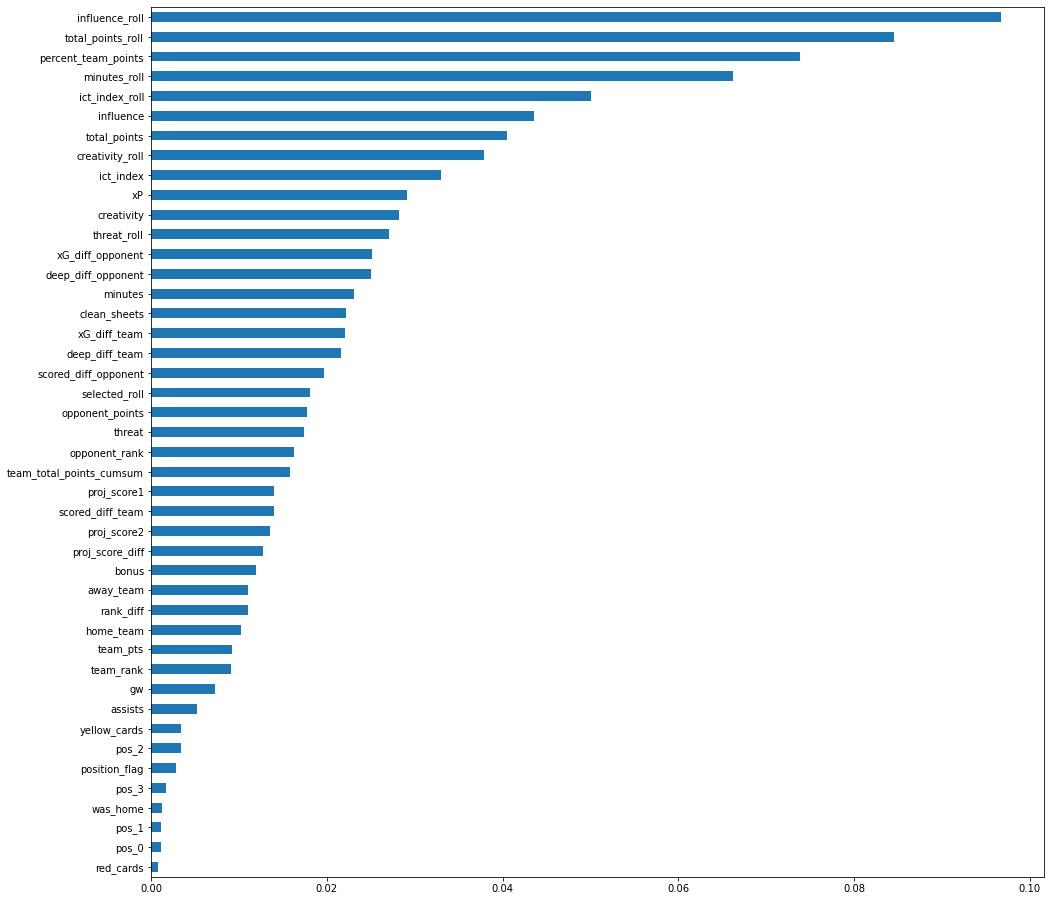

In [ ]:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

model_rf = RandomForestClassifier(n_estimators=100,max_depth=7, random_state=0,min_samples_split=5)
#class_weight='balanced_subsample'
model_rf.fit(X_train,Y_train)#Fitting the model 
#Generating predictions from Random Fores Models
pred_rf=model_rf.predict(X_test)
pred_rf_proba=model_rf.predict_proba(X_test)

feat_importances = pd.Series(model_rf.feature_importances_, index=X_train.columns)
feat_importances=feat_importances.sort_values()
feat_importances.plot(kind='barh',figsize=(16,16))#Plotting feature importance

print('Model Accuracy')
print(model_rf.score(X_test,Y_test))

In [ ]:
import statistics

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model_rf, X_train, Y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % statistics.mean(scores))

Mean ROC AUC: 0.791


0.2283340878113225


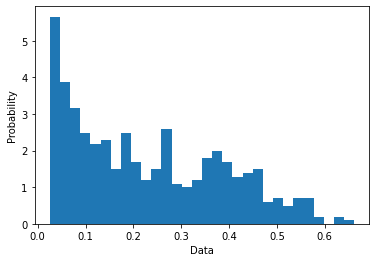

In [ ]:
import plotly.express as px
import matplotlib.pyplot as plt

def plot_hist(pred):
  plt.hist(pred[:,1], density=True, bins=30)  # density=False would make counts
  plt.ylabel('Probability')
  plt.xlabel('Data')

plot_hist(pred_rf_proba)
print(pred_rf_proba[:,1].mean())

Predicted    0    1  All
Actual                  
0          190  186  376
1           13   86   99
All        203  272  475


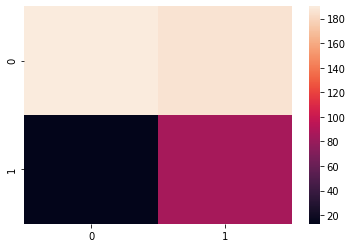

True Positive Rate [0.50531915 0.86868687]


In [ ]:
#Confusion Matrix & True Positive Rate
calc_pred=pred_rf_proba[:,1]>0.16
calc_pred=calc_pred.astype(int)

conf_mat = confusion_matrix(Y_test, calc_pred)
df_confusion = pd.crosstab(Y_test, calc_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print (df_confusion)

#print(conf_mat)

# Visualize it as a heatmap
import seaborn
import matplotlib.pyplot as plt

seaborn.heatmap(conf_mat)
plt.show()

FP = conf_mat.sum(axis=0) - np.diag(conf_mat)  
FN = conf_mat.sum(axis=1) - np.diag(conf_mat)
TP = np.diag(conf_mat)
TN = conf_mat.sum() - (FP + FN + TP)
TPR = TP/(TP+FN)

print("True Positive Rate",TPR)

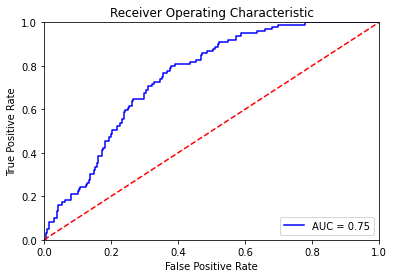

In [ ]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


def plot_curve(pred):
  fpr, tpr, threshold = metrics.roc_curve(Y_test, pred[:,1])
  roc_auc = metrics.auc(fpr, tpr)

# method I: plt
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
plot_curve(pred_rf_proba)

In [ ]:
# optimal_proba_cutoff = sorted(list(zip(np.abs(tpr - fpr), pred_rf_proba)), key=lambda i: i[0], reverse=True)[0][1]
# print(optimal_proba_cutoff)

# roc_predictions=calc_pred=pred_rf_proba[:,1]>0.26
# roc_predictions=roc_predictions.astype(int)

#roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_proba[:, -1]]

In [ ]:
# print("Accuracy Score Before and After Thresholding: {}, {}".format(accuracy_score(Y_test, roc_predictions), accuracy_score(Y_test, roc_predictions)))
# print("Precision Score Before and After Thresholding: {}, {}".format(precision_score(Y_test, roc_predictions), precision_score(Y_test, roc_predictions)))
# print("Recall Score Before and After Thresholding: {}, {}".format(recall_score(Y_test, roc_predictions), recall_score(Y_test, roc_predictions)))


 XGBoost

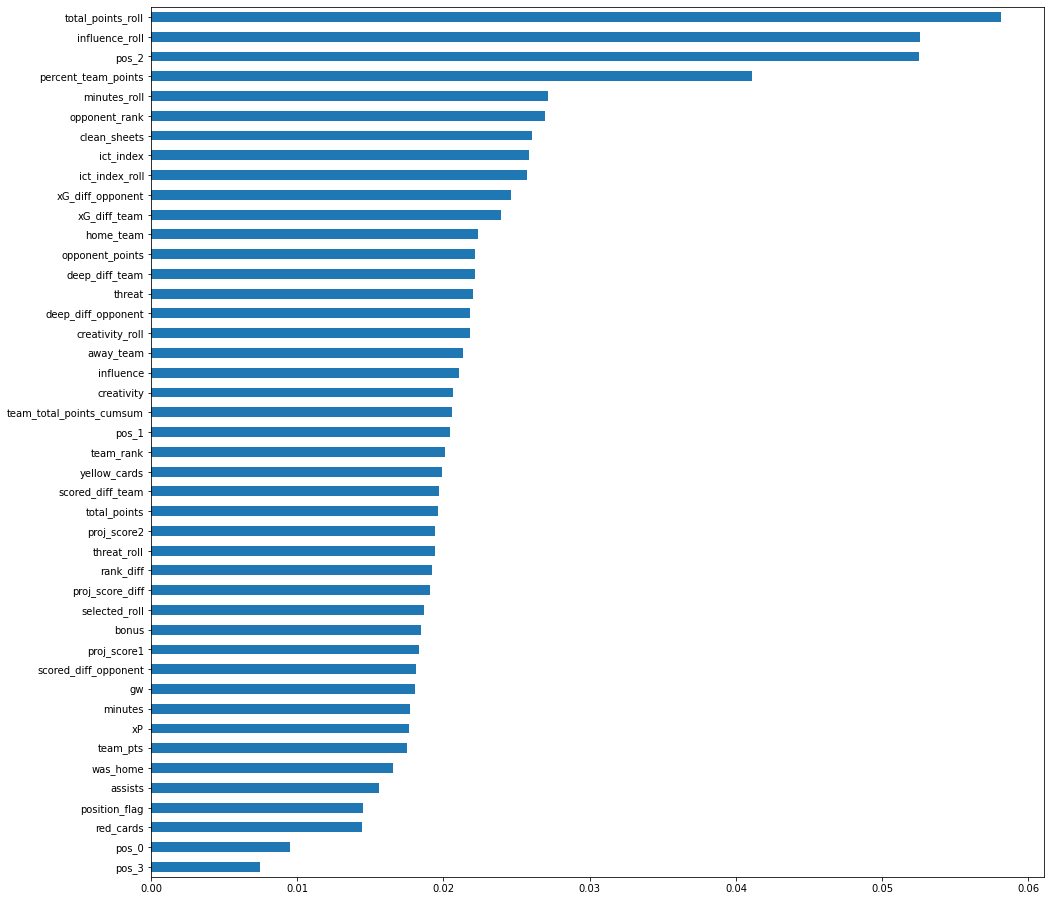

In [ ]:
from xgboost import XGBClassifier


model_xg = XGBClassifier(max_depth=7,
   # 'max_leaves' : 2**4,
    alpha=0.1, 
   # 'lambda' : 0.2,
   eta=0.1,
    subsample=0.7,
    min_child_weight =5,
    learning_rate=0.1, #default = 0.3,
    colsample_bytree=0.7,
    eval_metric='auc', 
    objective = 'binary:logistic',
    grow_policy='lossguide',
    n_estimators=100)
model_xg.fit(X_train, Y_train)
pred_xg_proba=model_xg.predict_proba(X_test)

feat_importances = pd.Series(model_xg.feature_importances_, index=X_train.columns)
feat_importances=feat_importances.sort_values()
feat_importances.plot(kind='barh',figsize=(16,16))#Plotting feature importance



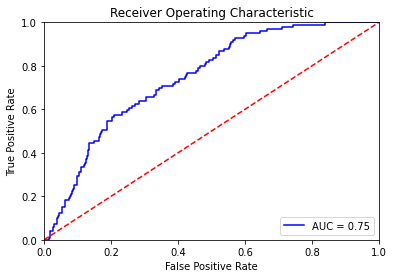

Predicted    0    1  All
Actual                  
0          247  129  376
1           30   69   99
All        277  198  475


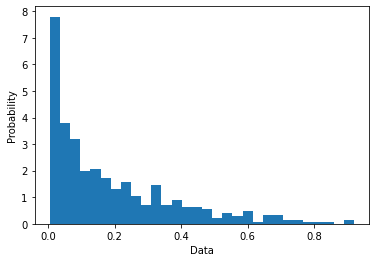

In [ ]:
plot_curve(pred_xg_proba)
plot_hist(pred_xg_proba)

calc_pred=pred_xg_proba[:,1]>0.16
calc_pred=calc_pred.astype(int)

conf_mat = confusion_matrix(Y_test, calc_pred)
df_confusion = pd.crosstab(Y_test, calc_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print (df_confusion)

In [ ]:
X_cols=weekly_data_subset_new_agg_pts_team2[['player_name','position','team','total_points','point_flag']].copy()
X_test_pred=pd.merge(X_test, X_cols, left_index=True, right_index=True)
#X_test_pred['predictions']=pred_rf_proba[:,1]
X_test_pred['predictions']=pred_xg_proba[:,1]


In [ ]:
X_test_pred.loc[X_test_pred['predictions']>0.5].sort_values(by='predictions',ascending=False).head(20)


,was_home,home_team,away_team,proj_score1,proj_score2,influence_roll,creativity_roll,threat_roll,ict_index_roll,minutes_roll,selected_roll,total_points_roll,red_cards,yellow_cards,xP,total_points_x,bonus,clean_sheets,assists,minutes,influence,creativity,threat,ict_index,team_pts,team_rank,xG_diff_team,deep_diff_team,scored_diff_team,opponent_points,gw,opponent_rank,xG_diff_opponent,deep_diff_opponent,scored_diff_opponent,rank_diff,proj_score_diff,team_total_points_cumsum,percent_team_points,position_flag,pos_0,pos_1,pos_2,pos_3,player_name,position,team,total_points_y,point_flag,predictions
2520,False,18,8,1.03,1.38,21.212500,22.781250,31.437500,7.543750,81.250000,6.255662e+04,3.625000,0,3,55.9,58,5,4,3,1300,339.4,364.5,503.0,120.7,13,14.0,-0.590980,0.396396,0.357143,11,20,15.0,-1.470378,0.285156,0.238095,-1.0,-0.35,633,0.091627,3,0,0,0,1,Ademola Lookman,MID,Fulham,58,0,0.920600
2523,False,18,8,1.03,1.38,17.905263,12.752632,8.789474,3.963158,81.105263,1.548767e+05,2.578947,0,4,37.7,49,4,4,3,1541,340.2,242.3,167.0,75.3,13,14.0,-0.590980,0.396396,0.357143,11,20,15.0,-1.470378,0.285156,0.238095,-1.0,-0.35,633,0.077409,3,0,0,0,1,André-Frank Zambo Anguissa,MID,Fulham,49,0,0.901406
2542,False,18,8,1.03,1.38,20.720000,1.880000,5.933333,2.873333,90.000000,1.159773e+04,3.266667,0,1,33.3,49,5,4,1,1350,310.8,28.2,89.0,43.1,13,14.0,-0.590980,0.396396,0.357143,11,20,15.0,-1.470378,0.285156,0.238095,-1.0,-0.35,633,0.077409,0,1,0,0,0,Tosin Adarabioyo,DEF,Fulham,49,0,0.839237
6921,False,5,4,1.91,0.58,14.852632,21.536842,4.000000,4.036842,90.000000,4.007800e+04,3.000000,0,4,47.2,57,2,7,3,1710,282.2,409.2,76.0,76.7,22,11.0,-0.695852,0.356061,0.351351,30,20,7.0,0.667273,0.587549,0.589286,4.0,1.33,716,0.079609,3,0,0,0,1,Ashley Westwood,MID,Burnley,57,0,0.828182
2529,False,18,8,1.03,1.38,14.893333,1.233333,0.866667,1.706667,76.066667,1.557933e+03,2.400000,1,2,20.6,36,2,4,0,1141,223.4,18.5,13.0,25.6,13,14.0,-0.590980,0.396396,0.357143,11,20,15.0,-1.470378,0.285156,0.238095,-1.0,-0.35,633,0.056872,0,1,0,0,0,Joachim Andersen,DEF,Fulham,36,0,0.797265
2528,False,18,8,1.03,1.38,9.400000,15.521053,18.789474,4.368421,67.315789,9.510263e+03,2.421053,0,1,40.4,46,4,3,0,1279,178.6,294.9,357.0,83.0,13,14.0,-0.590980,0.396396,0.357143,11,20,15.0,-1.470378,0.285156,0.238095,-1.0,-0.35,633,0.072670,3,0,0,0,1,Ivan Ricardo Neves Abreu Cavaleiro,MID,Fulham,46,1,0.749120
6518,True,6,20,1.19,1.16,20.620000,12.030000,33.850000,6.655000,76.000000,1.464735e+06,4.950000,0,3,93.3,99,11,3,3,1520,412.4,240.6,677.0,133.1,23,10.0,-0.572657,0.477912,0.400000,23,20,10.0,-0.315068,0.348214,0.420000,0.0,0.03,727,0.136176,3,0,0,0,1,Wilfried Zaha,MID,Crystal Palace,99,0,0.744352
2538,False,18,8,1.03,1.38,17.087500,7.968750,3.250000,2.825000,89.000000,2.107606e+04,3.250000,0,1,39.1,52,3,4,0,1424,273.4,127.5,52.0,45.2,13,14.0,-0.590980,0.396396,0.357143,11,20,15.0,-1.470378,0.285156,0.238095,-1.0,-0.35,633,0.082148,0,1,0,0,0,Ola Aina,DEF,Fulham,52,0,0.727088
3759,False,16,2,1.25,1.44,33.200000,46.522222,45.055556,12.466667,89.833333,2.448694e+06,6.277778,0,4,113.2,113,12,9,10,1617,597.6,837.4,811.0,224.4,29,8.0,0.778199,0.536765,0.611111,29,20,8.0,-0.319173,0.451327,0.529412,0.0,-0.19,920,0.122826,3,0,0,0,1,Jack Grealish,MID,Aston Villa,113,1,0.708945
3756,False,16,2,1.25,1.44,12.066667,10.983333,5.444444,2.861111,82.833333,2.084678e+04,2.388889,1,2,38.6,43,0,8,2,1491,217.2,197.7,98.0,51.5,29,8.0,0.778199,0.536765,0.611111,29,20,8.0,-0.319173,0.451327,0.529412,0.0,-0.19,920,0.046739,3,0,0,0,1,Douglas Luiz Soares de Paulo,MID,Aston Villa,43,1,0.704342


In [ ]:
#from google.colab import files

X_test_pred.to_csv('df.csv')
#files.download('df.csv')


In [ ]:
#weekly_data_subset['round'].max()


In [ ]:
#Prepare dataset for future game week predictions
fixtures_df1=fixtures_df[['event','team_h','team_a']]
max_week=weekly_data_subset['round'].max()
print(max_week)

#UNCOMMENT THIS LATER
#pred_data=weekly_data_subset.loc[weekly_data_subset['round']==max_week]
pred_data=weekly_data_subset
fixtures_df1=fixtures_df1.loc[fixtures_df1['event']==max_week+1]

#fixtures_df1=fixtures_df1.loc[fixtures_df1['event']==max_week]

pred_data=pred_data[['player_name','position','team','team_id','round']].reset_index(drop=True)
pred_data=pred_data.drop_duplicates(subset=['player_name','position','team','team_id'])
pred_data['round']=16
print(pred_data.shape)
pred_data
#fixtures_df

pred_data=pd.merge(left=pred_data,right=fixtures_df1,left_on='team_id',right_on='team_h',how='left')
pred_data=pd.merge(left=pred_data,right=fixtures_df1,left_on='team_id',right_on='team_a',how='left')

pred_data.loc[pred_data['team_h_x'].isna(),'team_h_x']=pred_data.loc[pred_data['team_h_x'].isna(),'team_h_y']
pred_data.loc[pred_data['team_a_x'].isna(),'team_a_x']=pred_data.loc[pred_data['team_a_x'].isna(),'team_a_y']
pred_data=pred_data[['player_name','position','team','team_id','team_h_x','team_a_x','round']]
pred_data=pred_data.rename(columns={"round": "gw","team_h_x": "home_team","team_a_x":"away_team"})

# #weekly_data_subset_new=weekly_data_subset[['player_name','gw','position','team','round','team_id','opponent_id','selected','was_home','home_team','away_team','proj_score1','proj_score2','point_flag']].copy()

# #Home Flag
pred_data['was_home']=0
pred_data.loc[pred_data['home_team']==pred_data['team_id'],'was_home']=1

#TOBECHANGED
pred_data['gw']=GW-1

pred_data['opponent_id']=0

pred_data['opponent_id']=pred_data['home_team']
pred_data.loc[pred_data['was_home']==1,'opponent_id']=pred_data.loc[pred_data['was_home']==1,'away_team']
#pred_data

#Rolling means dataset. Take latest available record for a player to account for empty gameweeks or covid cancellations
weekly_rolling_means_latest_stats=weekly_rolling_means.sort_values(by='gw',ascending=False).groupby('player_name').head(1)
weekly_rolling_means_latest_stats['gw']=max_week

pred_data_roll=pd.merge(left=pred_data,right=weekly_rolling_means_latest_stats,left_on=['player_name','gw'],right_on=['player_name','gw'],how='inner')

# #Merge cumulative means
gp_cumsum_latest_stats=gp_cumsum.sort_values(by='gw',ascending=False).groupby('player_name').head(1)
gp_cumsum_latest_stats['gw']=max_week
pred_data_roll_cum=pd.merge(left=pred_data_roll,right=gp_cumsum_latest_stats,left_on=['player_name','gw'],right_on=['player_name','gw'],how='inner')
#pred_data_roll_cum

# # #Merge team total ranking stats with home team
#Calculate latest availalbe team stats for the team. Useful when teams have blank gameweeks and are not playing in the game
latest_rank=team_total_data_id.sort_values(by='gw',ascending=False).groupby('id').head(1)
latest_rank['gw']=max_week
pred_data_roll_cum_team=pd.merge(left=pred_data_roll_cum,right=latest_rank,left_on=['team_id','gw'],right_on=['id','gw'])
pred_data_roll_cum_team=pred_data_roll_cum_team.rename(columns={"rank": "team_rank",'cum_pts':'team_pts','xG_diff':'xG_diff_team','scored_diff':'scored_diff_team','deep_diff':'deep_diff_team'})

# # #Merge team total ranking stats with away team
pred_data_roll_cum_team=pd.merge(left=pred_data_roll_cum_team,right=latest_rank,left_on=['opponent_id','gw'],right_on=['id','gw'])
pred_data_roll_cum_team=pred_data_roll_cum_team.rename(columns={"rank": "opponent_rank",'cum_pts':'opponent_points','xG_diff':'xG_diff_opponent','scored_diff':'scored_diff_opponent','deep_diff':'deep_diff_opponent'})
pred_data_roll_cum_team

# #Merge team total ranking stats with away team
team_gp_latest=team_gp.sort_values(by='round',ascending=False).groupby('team_id').head(1)
team_gp_latest['round']=max_week
pred_data_roll_cum_team_pts=pd.merge(left=pred_data_roll_cum_team,right=team_gp_latest,left_on=['team_id','gw'],right_on=['team_id','round'],how='inner')
pred_data_roll_cum_team_pts['percent_team_points']=pred_data_roll_cum_team_pts['total_points']/pred_data_roll_cum_team_pts['team_total_points_cumsum']
pred_data_roll_cum_team_pts['gw']=max_week+1

pred_data_roll_cum_team_pts_spi=pd.merge(left=pred_data_roll_cum_team_pts,right=spi_data_name_fil,left_on=['home_team','away_team'],right_on=['home_id','away_id'],how='inner')

# #Calculate rank and projected score differences for the upcoming fixture
pred_data_roll_cum_team_pts_spi['rank_diff']=pred_data_roll_cum_team_pts_spi['team_rank']-pred_data_roll_cum_team_pts_spi['opponent_rank']
pred_data_roll_cum_team_pts_spi['proj_score_diff']=pred_data_roll_cum_team_pts_spi['proj_score1']-pred_data_roll_cum_team_pts_spi['proj_score2']

#pred_data_roll_cum_team_pts_spi

21
(486, 5)


In [ ]:
pred_data_roll_cum_team_pts_spi.shape

(486, 51)

In [ ]:
# pred_data_roll=pd.merge(left=pred_data,right=weekly_rolling_means_latest_stats,left_on=['player_name','gw'],right_on=['player_name','gw'],how='left')
# pred_data_roll.loc[pred_data_roll.influence_roll.isna()]
team_gp

,team_id,round,team_total_points_cumsum
0,1,1,82
1,1,2,128
2,1,3,151
3,1,4,196
4,1,5,221
...,...,...,...
394,20,17,651
395,20,18,679
396,20,19,712
397,20,20,763


In [ ]:
pred_data_roll_cum_team_pts_spi['position_flag'] = labelencoder.fit_transform(pred_data_roll_cum_team_pts_spi['position'])
cols = pd.get_dummies(pred_data_roll_cum_team_pts_spi['position_flag'])
cols.columns = ['pos_0','pos_1','pos_2','pos_3']
pred_data_roll_cum_team_pts_spi1 = pd.concat([pred_data_roll_cum_team_pts_spi, cols], axis=1)
pred_data_roll_cum_team_pts_spi1

pred_data_roll_cum_team_pts_spi1.drop(['player_name','position','team','team1','team2','away_id','home_id','id_x','id_y','opponent_id','team_id','round'],axis=1,inplace=True)

#Reorder columns in the test data to be in the same order as train data
pred_data_roll_cum_team_pts_spi1=pred_data_roll_cum_team_pts_spi1[X_train.columns]
proba_rf=model_rf.predict_proba(pred_data_roll_cum_team_pts_spi1)
proba_xg=model_xg.predict_proba(pred_data_roll_cum_team_pts_spi1)

#pred_data_roll_cum_team_pts_spi['predicted']=proba_rf[:,1]

#pred_data_roll_cum_team_pts_spi['predicted']=proba_xg[:,1]
pred_data_roll_cum_team_pts_spi['predicted']=0.7*proba_rf[:,1]+0.3*proba_xg[:,1]

In [ ]:
pred_data_roll_cum_team_pts_spi.team.unique()

array(['Brighton', 'Liverpool', 'West Ham', 'Aston Villa',
       'Sheffield Utd', 'West Brom', 'Man Utd', 'Southampton', 'Everton',
       'Leeds', 'Fulham', 'Leicester', 'Wolves', 'Arsenal', 'Newcastle',
       'Crystal Palace', 'Chelsea', 'Spurs', 'Burnley', 'Man City'],
      dtype=object)

In [ ]:
pred_data_roll_cum_team_pts_spi.sort_values(by='predicted',ascending=False).head(15)

,player_name,position,team,team_id,home_team,away_team,gw,was_home,opponent_id,influence_roll,creativity_roll,threat_roll,ict_index_roll,minutes_roll,selected_roll,total_points_roll,red_cards,yellow_cards,xP,total_points,bonus,clean_sheets,assists,minutes,influence,creativity,threat,ict_index,team_pts,id_x,team_rank,xG_diff_team,deep_diff_team,scored_diff_team,opponent_points,id_y,opponent_rank,xG_diff_opponent,deep_diff_opponent,scored_diff_opponent,round,team_total_points_cumsum,percent_team_points,team1,team2,home_id,away_id,proj_score1,proj_score2,rank_diff,proj_score_diff,position_flag,predicted
466,Ederson Santana de Moraes,GK,Man City,12,4.0,12.0,22,0,4.0,13.740000,0.000000,0.000000,1.380000,85.500000,4.609512e+05,4.400000,0,1,110.1,88,1,12,0,1710,274.8,0.0,0.0,27.6,44,12,1.0,1.294208,0.750865,0.740000,22,4,12.0,-0.713549,0.336770,0.333333,21,1134,0.077601,Burnley,Manchester City,4,12,0.49,2.25,-11.0,-1.76,2,0.730635
471,Ilkay Gündogan,MID,Man City,12,4.0,12.0,22,0,4.0,19.790000,17.685000,16.500000,5.400000,56.250000,1.693185e+05,4.150000,0,0,104.5,83,12,9,0,1125,395.8,353.7,330.0,108.0,44,12,1.0,1.294208,0.750865,0.740000,22,4,12.0,-0.713549,0.336770,0.333333,21,1134,0.073192,Burnley,Manchester City,4,12,0.49,2.25,-11.0,-1.76,3,0.690731
481,Riyad Mahrez,MID,Man City,12,4.0,12.0,22,0,4.0,15.350000,21.205000,22.650000,5.915000,47.100000,3.575458e+05,3.500000,0,0,101.7,70,7,7,2,942,307.0,424.1,453.0,118.3,44,12,1.0,1.294208,0.750865,0.740000,22,4,12.0,-0.713549,0.336770,0.333333,21,1134,0.061728,Burnley,Manchester City,4,12,0.49,2.25,-11.0,-1.76,3,0.688607
244,Ademola Lookman,MID,Fulham,8,8.0,9.0,22,1,9.0,20.341176,22.500000,31.647059,7.447059,81.764706,6.473088e+04,3.529412,0,3,59.3,60,5,4,3,1390,345.8,382.5,538.0,126.6,14,8,14.0,-0.535142,0.414847,0.369565,39,9,4.0,0.349518,0.556034,0.596774,21,671,0.089419,Fulham,Leicester City,8,9,0.97,1.54,10.0,-0.57,3,0.667287
473,João Pedro Cavaco Cancelo,DEF,Man City,12,4.0,12.0,22,0,4.0,16.610000,21.850000,9.850000,4.835000,63.950000,4.679078e+05,4.300000,0,3,104.4,86,13,9,2,1279,332.2,437.0,197.0,96.7,44,12,1.0,1.294208,0.750865,0.740000,22,4,12.0,-0.713549,0.336770,0.333333,21,1134,0.075838,Burnley,Manchester City,4,12,0.49,2.25,-11.0,-1.76,0,0.666357
320,Bukayo Saka,MID,Arsenal,1,20.0,1.0,22,0,20.0,17.828571,18.304762,30.714286,6.685714,71.571429,3.791516e+05,3.857143,0,0,77.1,81,8,6,3,1503,374.4,384.4,645.0,140.4,31,1,8.0,0.226947,0.570370,0.565217,23,20,11.0,-0.343772,0.346320,0.411765,21,929,0.087191,Wolverhampton,Arsenal,20,1,1.06,1.35,-3.0,-0.29,3,0.627423
482,Rodrigo Hernandez,MID,Man City,12,4.0,12.0,22,0,4.0,15.350000,14.055000,9.300000,3.875000,77.100000,3.570875e+04,2.300000,0,3,71.5,46,3,8,1,1542,307.0,281.1,186.0,77.5,44,12,1.0,1.294208,0.750865,0.740000,22,4,12.0,-0.713549,0.336770,0.333333,21,1134,0.040564,Burnley,Manchester City,4,12,0.49,2.25,-11.0,-1.76,3,0.615653
390,Wilfried Zaha,MID,Crystal Palace,6,14.0,6.0,22,0,14.0,19.638095,12.276190,33.333333,6.528571,76.666667,1.450886e+06,4.809524,0,4,96.3,101,11,4,3,1610,412.4,257.8,700.0,137.1,26,6,10.0,-0.501680,0.484375,0.409836,22,14,12.0,-0.572762,0.290076,0.381818,21,786,0.128499,Newcastle,Crystal Palace,14,6,1.25,1.07,-2.0,0.18,3,0.599962
96,Aaron Ramsdale,GK,Sheffield Utd,15,15.0,18.0,22,1,18.0,22.876190,0.476190,0.190476,2.352381,90.000000,2.368946e+05,2.523810,0,1,46.3,53,2,1,0,1890,480.4,10.0,4.0,49.4,8,15,16.0,-0.550331,0.437037,0.260870,12,18,15.0,-1.425397,0.277567,0.253731,21,540,0.098148,Sheffield United,West Bromwich Albion,15,18,1.52,0.81,1.0,0.71,2,0.590660
480,Raheem Sterling,MID,Man City,12,4.0,12.0,22,0,4.0,19.280000,15.505000,40.200000,7.490000,71.900000,4.356275e+05,4.850000,0,1,122.4,97,9,9,6,1438,385.6,310.1,804.0,149.8,44,12,1.0,1.294208,0.750865,0.740000,22,4,12.0,-0.713549,0.336770,0.333333,21,1134,0.085538,Burnley,Manchester City,4,12,0.49,2.25,-11.0,-1.76,3,0.584465


In [ ]:
players_df_100=players_df.loc[(players_df['chance_of_playing_next_round']!=0)&(players_df['chance_of_playing_next_round']!=75)&(players_df['chance_of_playing_next_round']!=25)&(players_df['chance_of_playing_next_round']!=50)]
players_df_100=players_df_100[['first_name','second_name','photo','code','team']]
#players_df_100
players_df_100['web_name']=players_df_100['first_name']+' '+players_df_100['second_name']

pred_data_roll_cum_team_pts_spi_100=pd.merge(left=pred_data_roll_cum_team_pts_spi,right=players_df_100,left_on=['player_name','team_id'],right_on=['web_name','team'],how='inner')
del pred_data_roll_cum_team_pts_spi_100['team_y']
pred_data_roll_cum_team_pts_spi_100

,player_name,position,team_x,team_id,home_team,away_team,gw,was_home,opponent_id,influence_roll,creativity_roll,threat_roll,ict_index_roll,minutes_roll,selected_roll,total_points_roll,red_cards,yellow_cards,xP,total_points,bonus,clean_sheets,assists,minutes,influence,creativity,threat,ict_index,team_pts,id_x,team_rank,xG_diff_team,deep_diff_team,scored_diff_team,opponent_points,id_y,opponent_rank,xG_diff_opponent,deep_diff_opponent,scored_diff_opponent,round,team_total_points_cumsum,percent_team_points,team1,team2,home_id,away_id,proj_score1,proj_score2,rank_diff,proj_score_diff,position_flag,predicted,first_name,second_name,photo,code,web_name
0,Aaron Connolly,FWD,Brighton,3,11.0,3.0,22,0,11.0,4.704762,2.890476,11.190476,1.871429,27.952381,35626.095238,1.476190,0,0,26.8,31,2,1,1,587,98.8,60.7,235.0,39.3,21,3,13.0,0.305884,0.611722,0.442308,40,11,3.0,0.805659,0.804217,0.641791,21,800,0.038750,Liverpool,Brighton and Hove Albion,11,3,2.09,0.77,10.0,1.32,1,0.134720,Aaron,Connolly,233425.jpg,233425,Aaron Connolly
1,Adam Lallana,MID,Brighton,3,11.0,3.0,22,0,11.0,4.800000,9.390476,5.571429,1.957143,36.904762,32346.238095,1.333333,0,0,20.3,28,0,3,1,775,100.8,197.2,117.0,41.1,21,3,13.0,0.305884,0.611722,0.442308,40,11,3.0,0.805659,0.804217,0.641791,21,800,0.035000,Liverpool,Brighton and Hove Albion,11,3,2.09,0.77,10.0,1.32,3,0.169970,Adam,Lallana,39155.jpg,39155,Adam Lallana
2,Adam Webster,DEF,Brighton,3,11.0,3.0,22,0,11.0,14.809524,3.742857,9.619048,2.814286,85.714286,138536.428571,2.523810,0,3,41.5,53,0,6,0,1800,311.0,78.6,202.0,59.1,21,3,13.0,0.305884,0.611722,0.442308,40,11,3.0,0.805659,0.804217,0.641791,21,800,0.066250,Liverpool,Brighton and Hove Albion,11,3,2.09,0.77,10.0,1.32,0,0.248905,Adam,Webster,110735.jpg,110735,Adam Webster
3,Andi Zeqiri,FWD,Brighton,3,11.0,3.0,22,0,11.0,0.023529,0.300000,3.705882,0.400000,3.705882,3268.647059,0.117647,0,0,1.6,2,0,0,0,63,0.4,5.1,63.0,6.8,21,3,13.0,0.305884,0.611722,0.442308,40,11,3.0,0.805659,0.804217,0.641791,21,800,0.002500,Liverpool,Brighton and Hove Albion,11,3,2.09,0.77,10.0,1.32,1,0.049812,Andi,Zeqiri,204676.jpg,204676,Andi Zeqiri
4,Ben White,DEF,Brighton,3,11.0,3.0,22,0,11.0,13.114286,5.695238,3.000000,2.190476,83.761905,97500.333333,2.619048,0,2,41.7,55,2,6,0,1759,275.4,119.6,63.0,46.0,21,3,13.0,0.305884,0.611722,0.442308,40,11,3.0,0.805659,0.804217,0.641791,21,800,0.068750,Liverpool,Brighton and Hove Albion,11,3,2.09,0.77,10.0,1.32,0,0.237101,Ben,White,198869.jpg,198869,Ben White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,Raheem Sterling,MID,Man City,12,4.0,12.0,22,0,4.0,19.280000,15.505000,40.200000,7.490000,71.900000,435627.550000,4.850000,0,1,122.4,97,9,9,6,1438,385.6,310.1,804.0,149.8,44,12,1.0,1.294208,0.750865,0.740000,22,4,12.0,-0.713549,0.336770,0.333333,21,1134,0.085538,Burnley,Manchester City,4,12,0.49,2.25,-11.0,-1.76,3,0.584465,Raheem,Sterling,103955.jpg,103955,Raheem Sterling
366,Riyad Mahrez,MID,Man City,12,4.0,12.0,22,0,4.0,15.350000,21.205000,22.650000,5.915000,47.100000,357545.800000,3.500000,0,0,101.7,70,7,7,2,942,307.0,424.1,453.0,118.3,44,12,1.0,1.294208,0.750865,0.740000,22,4,12.0,-0.713549,0.336770,0.333333,21,1134,0.061728,Burnley,Manchester City,4,12,0.49,2.25,-11.0,-1.76,3,0.688607,Riyad,Mahrez,103025.jpg,103025,Riyad Mahrez
367,Rodrigo Hernandez,MID,Man City,12,4.0,12.0,22,0,4.0,15.350000,14.055000,9.300000,3.875000,77.100000,35708.750000,2.300000,0,3,71.5,46,3,8,1,1542,307.0,281.1,186.0,77.5,44,12,1.0,1.294208,0.750865,0.740000,22,4,12.0,-0.713549,0.336770,0.333333,21,1134,0.040564,Burnley,Manchester City,4,12,0.49,2.25,-11.0,-1.76,3,0.615653,Rodrigo,Hernandez,220566.jpg,220566,Rodrigo Hernandez
368,Rúben Santos Gato Alves Dias,DEF,Man City,12,4.0,12.0,22,0,4.0,20.033333,1.788889,9.111111,3.100000,88.833333,451309.166667,5.055556,0,2,118.4,91,9,12,1,1599,360.6

In [ ]:
players_df.loc[players_df['web_name']=='Kane']

,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,ep_this,event_points,first_name,form,id,in_dreamteam,news,news_added,now_cost,photo,points_per_game,second_name,selected_by_percent,special,squad_number,status,team,team_code,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,influence_rank,influence_rank_type,creativity_rank,creativity_rank_type,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,direct_freekicks_order,direct_freekicks_text,penalties_order,penalties_text
519,0.0,0.0,78830,-1,1,6,-6,6,4,0.0,0.0,0,Harry,4.5,388,True,Ankle injury - Unknown return date,2021-01-28T23:00:26.163676Z,111,78830.jpg,7.5,Kane,22.9,False,None,i,17,6,143,4479590,2439,4187537,650925,0.4,12.9,Kane,1654,12,11,6,17,0,0,0,1,0,0,26,512,763.4,371.2,792.0,192.4,2,1,28,1,9,5,5,1,NaN,,1.0,,1.0,


In [ ]:
from google.colab import files
pred_data_roll_cum_team_pts_spi_100.to_csv('pred.csv')
files.download('pred.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# pred_data_roll_cum_team_pts_spi.sort_values(by='predicted',ascending=False,inplace=True)

# team_list=[]

# gk=pred_data_roll_cum_team_pts_spi.loc[pred_data_roll_cum_team_pts_spi['position']=='GK',['player_name','position','team_id','gw']].head(1)
# team_list.append(gk)

# defender=pred_data_roll_cum_team_pts_spi.loc[pred_data_roll_cum_team_pts_spi['position']=='DEF',['player_name','position','team_id','gw']].head(3)
# team_list.append(defender)
# midfielder=pred_data_roll_cum_team_pts_spi.loc[pred_data_roll_cum_team_pts_spi['position']=='MID',['player_name','position','team_id','gw']].head(4)
# team_list.append(midfielder)
# forward=pred_data_roll_cum_team_pts_spi.loc[pred_data_roll_cum_team_pts_spi['position']=='FWD',['player_name','position','team_id','gw']].head(3)
# team_list.append(forward)

# team_list

In [ ]:
pred_data_roll_cum_team_pts_spi_100.sort_values(by='predicted',ascending=False,inplace=True)
pred_data_roll_cum_team_pts_spi_100['team']=pred_data_roll_cum_team_pts_spi_100['team_x']
team_list=pred_data_roll_cum_team_pts_spi_100.team.unique()
team_frame=pd.DataFrame({'team':team_list})
team_frame['count']=0

loop_df=pred_data_roll_cum_team_pts_spi_100[['player_name','position','team']]
loop_df=loop_df.reset_index(drop=True)
#loop_df
form=[1,3,4,3]
form_type=['GK','DEF','MID','FWD']
player_list=[]
k=0
j=0
for i in range(4):
  j=0
 # for j in range(form[i]):
  while True:
    temp=loop_df.loc[loop_df.position==form_type[i]].head(1)
    team_name=temp.iloc[0]['team']
    player=temp.iloc[0]['player_name']
    #print(player,team_name)
    team_frame.loc[team_frame.team==team_name,'count']=team_frame.loc[team_frame.team==team_name,'count']+1
    chk= team_frame.loc[team_frame.team==team_name]
    cnt=chk.iloc[0]['count']
 #   print(player)
 #   print(cnt)
    if cnt<=3:
      player_list.append(player)
    else :
      j=j-1
    loop_df=loop_df.loc[loop_df.player_name!=player]
    j=j+1
    if(j>=form[i]):
      break
  #  print(j)

  #  loop_df=loop_df.drop(loop_df.head(1).index)
 #   loop_df=loop_df.reset_index(drop=True)
player_list

['Ederson Santana de Moraes',
 'João Pedro Cavaco Cancelo',
 'John Stones',
 'Aaron Cresswell',
 'Ademola Lookman',
 'Wilfried Zaha',
 'James Maddison',
 'Jack Grealish',
 'Ollie Watkins',
 'Callum Wilson',
 'Dominic Calvert-Lewin']

In [ ]:
output=pred_data_roll_cum_team_pts_spi_100.loc[pred_data_roll_cum_team_pts_spi_100.player_name.isin(player_list)]
output=output[['player_name','position','team_id','gw']]
output

,player_name,position,team_id,gw
353,Ederson Santana de Moraes,GK,12,22
182,Ademola Lookman,MID,8,22
360,João Pedro Cavaco Cancelo,DEF,12,22
289,Wilfried Zaha,MID,6,22
359,John Stones,DEF,12,22
209,James Maddison,MID,9,22
36,Aaron Cresswell,DEF,19,22
60,Jack Grealish,MID,2,22
69,Ollie Watkins,FWD,2,22
255,Callum Wilson,FWD,14,22




## Optimization


In [ ]:
!pip install pulp

In [ ]:
#LP Approach
# import pulp

# def select_team(expected_scores, prices, positions, clubs, total_budget=1000, sub_factor=0.2):
#     num_players = len(expected_scores)
#     print(num_players)
#     model = pulp.LpProblem("Constrained value maximisation", pulp.LpMaximize)
#     decisions = [
#         pulp.LpVariable("x{}".format(i), lowBound=0, upBound=1, cat='Integer')
#         for i in range(num_players)
#     ]
#     captain_decisions = [
#         pulp.LpVariable("y{}".format(i), lowBound=0, upBound=1, cat='Integer')
#         for i in range(num_players)
#     ]
#     sub_decisions = [
#         pulp.LpVariable("z{}".format(i), lowBound=0, upBound=1, cat='Integer')
#         for i in range(num_players)
#     ]


#     # objective function:
#     model += sum((captain_decisions[i] + decisions[i] + sub_decisions[i]*sub_factor) * expected_scores[i]
#                  for i in range(num_players)), "Objective"

#     # cost constraint
#     model += sum((decisions[i] + sub_decisions[i]) * prices[i] for i in range(num_players)) <= total_budget  # total cost

#     # position constraints
#     # 1 starting goalkeeper
#     model += sum(decisions[i] for i in range(num_players) if positions[i] == 1) == 1
#     # 2 total goalkeepers
#     model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 1) == 2

#     # 3-5 starting defenders
#     model += sum(decisions[i] for i in range(num_players) if positions[i] == 2) >= 3
#     model += sum(decisions[i] for i in range(num_players) if positions[i] == 2) <= 5
#     # 5 total defenders
#     model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 2) == 5

#     # 3-5 starting midfielders
#     model += sum(decisions[i] for i in range(num_players) if positions[i] == 3) >= 3
#     model += sum(decisions[i] for i in range(num_players) if positions[i] == 3) <= 5
#     # 5 total midfielders
#     model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 3) == 5

#     # 1-3 starting attackers
#     model += sum(decisions[i] for i in range(num_players) if positions[i] == 4) >= 1
#     model += sum(decisions[i] for i in range(num_players) if positions[i] == 4) <= 3
#     # 3 total attackers
#     model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 4) == 3

#     # club constraint
#     for club_id in np.unique(clubs):
#         model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if clubs[i] == club_id) <= 3  # max 3 players

#     model += sum(decisions) == 11  # total team size
#     model += sum(captain_decisions) == 1  # 1 captain
    
#     for i in range(num_players):  
#         model += (decisions[i] - captain_decisions[i]) >= 0  # captain must also be on team
#         model += (decisions[i] + sub_decisions[i]) <= 1  # subs must not be on team

#     model.solve()
#     print("Total expected score = {}".format(model.objective.value()))

#     return decisions, captain_decisions, sub_decisions

In [ ]:
# #pred_data_roll_cum_team_pts_spi
cost_df=players_df[['now_cost','first_name','second_name']].copy()
cost_df['web_name']=cost_df['first_name']+' '+cost_df['second_name']
#cost_df

pred_data_roll_cum_team_pts_spi_cost=pd.merge(left=pred_data_roll_cum_team_pts_spi,right=cost_df,left_on=['player_name'],right_on=['web_name'],how='inner')
pred_data_roll_cum_team_pts_spi_cost


# expected_scores=pred_data_roll_cum_team_pts_spi_cost['predicted']
# prices=pred_data_roll_cum_team_pts_spi_cost['now_cost']
# positions=pred_data_roll_cum_team_pts_spi_cost['position']
# clubs=pred_data_roll_cum_team_pts_spi_cost['team_id']

# decision,captain_decision,sub_decisions=select_team(expected_scores.values, prices.values, positions.values, clubs.values, total_budget=100,sub_factor=0.2)
# #expected_scores.values


,player_name,position,team,team_id,home_team,away_team,gw,was_home,opponent_id,influence_roll,creativity_roll,threat_roll,ict_index_roll,minutes_roll,selected_roll,total_points_roll,red_cards,yellow_cards,xP,total_points,bonus,clean_sheets,assists,minutes,influence,creativity,threat,ict_index,team_pts,id_x,team_rank,xG_diff_team,deep_diff_team,scored_diff_team,opponent_points,id_y,opponent_rank,xG_diff_opponent,deep_diff_opponent,scored_diff_opponent,round,team_total_points_cumsum,percent_team_points,team1,team2,home_id,away_id,proj_score1,proj_score2,rank_diff,proj_score_diff,position_flag,predicted,now_cost,first_name,second_name,web_name
0,Aaron Connolly,FWD,Brighton,3,11.0,3.0,22,0,11.0,4.704762,2.890476,11.190476,1.871429,27.952381,35626.095238,1.476190,0,0,26.8,31,2,1,1,587,98.8,60.7,235.0,39.3,21,3,13.0,0.305884,0.611722,0.442308,40,11,3.0,0.805659,0.804217,0.641791,21,800,0.038750,Liverpool,Brighton and Hove Albion,11,3,2.09,0.77,10.0,1.32,1,0.134720,52,Aaron,Connolly,Aaron Connolly
1,Adam Lallana,MID,Brighton,3,11.0,3.0,22,0,11.0,4.800000,9.390476,5.571429,1.957143,36.904762,32346.238095,1.333333,0,0,20.3,28,0,3,1,775,100.8,197.2,117.0,41.1,21,3,13.0,0.305884,0.611722,0.442308,40,11,3.0,0.805659,0.804217,0.641791,21,800,0.035000,Liverpool,Brighton and Hove Albion,11,3,2.09,0.77,10.0,1.32,3,0.169970,62,Adam,Lallana,Adam Lallana
2,Adam Webster,DEF,Brighton,3,11.0,3.0,22,0,11.0,14.809524,3.742857,9.619048,2.814286,85.714286,138536.428571,2.523810,0,3,41.5,53,0,6,0,1800,311.0,78.6,202.0,59.1,21,3,13.0,0.305884,0.611722,0.442308,40,11,3.0,0.805659,0.804217,0.641791,21,800,0.066250,Liverpool,Brighton and Hove Albion,11,3,2.09,0.77,10.0,1.32,0,0.248905,44,Adam,Webster,Adam Webster
3,Alexis Mac Allister,MID,Brighton,3,11.0,3.0,22,0,11.0,4.961905,4.876190,4.333333,1.409524,21.428571,3277.619048,1.285714,0,1,20.1,27,3,3,1,450,104.2,102.4,91.0,29.6,21,3,13.0,0.305884,0.611722,0.442308,40,11,3.0,0.805659,0.804217,0.641791,21,800,0.033750,Liverpool,Brighton and Hove Albion,11,3,2.09,0.77,10.0,1.32,3,0.132521,53,Alexis,Mac Allister,Alexis Mac Allister
4,Alireza Jahanbakhsh,MID,Brighton,3,11.0,3.0,22,0,11.0,2.447619,4.500000,6.809524,1.371429,11.857143,2905.714286,0.619048,0,2,8.2,13,0,0,1,249,51.4,94.5,143.0,28.8,21,3,13.0,0.305884,0.611722,0.442308,40,11,3.0,0.805659,0.804217,0.641791,21,800,0.016250,Liverpool,Brighton and Hove Albion,11,3,2.09,0.77,10.0,1.32,3,0.100761,54,Alireza,Jahanbakhsh,Alireza Jahanbakhsh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,Riyad Mahrez,MID,Man City,12,4.0,12.0,22,0,4.0,15.350000,21.205000,22.650000,5.915000,47.100000,357545.800000,3.500000,0,0,101.7,70,7,7,2,942,307.0,424.1,453.0,118.3,44,12,1.0,1.294208,0.750865,0.740000,22,4,12.0,-0.713549,0.336770,0.333333,21,1134,0.061728,Burnley,Manchester City,4,12,0.49,2.25,-11.0,-1.76,3,0.688607,81,Riyad,Mahrez,Riyad Mahrez
482,Rodrigo Hernandez,MID,Man City,12,4.0,12.0,22,0,4.0,15.350000,14.055000,9.300000,3.875000,77.100000,35708.750000,2.300000,0,3,71.5,46,3,8,1,1542,307.0,281.1,186.0,77.5,44,12,1.0,1.294208,0.750865,0.740000,22,4,12.0,-0.713549,0.336770,0.333333,21,1134,0.040564,Burnley,Manchester City,4,12,0.49,2.25,-11.0,-1.76,3,0.615653,53,Rodrigo,Hernandez,Rodrigo Hernandez
483,Rúben Santos Gato Alves Dias,DEF,Man City,12,4.0,12.0,22,0,4.0,20.033333,1.788889,9.111111,3.100000,88.833333,451309.166667,5.055556,0,2,118.4,91,9,12,1,1599,360.6,32.2,164.0,55.8,44,12,1.0,1.294208,0.750865,0.740000,22,4,12.0,-0.713549,0.336770,0.333333,21,1134,0.080247,Burnley,Manchester City,4,12,0.49,2.25,-11.0,-1.76,0,0.536733,60,Rúben Santos,Gato Alves Dias,Rúben Santos Gato Alves Dias
484,Sergio Agüero,FWD,Man City,12,4.0,12.0,22,0,4.0,0.360000,1.845000,3.250000,0.520000,7.000000,113363.150000,0.300000,0,0,9.6,6,0,1,0,140,7.2,36.9,65.0,10.4,44,12,1.0,1.294208,0.750865,0.740000,22,

In [ ]:
#expected_scores.values


In [ ]:

#output=pd.concat(team_list)

output['web_name'] = output['player_name'].str.split(' ').str[1]
player_photo=players_df[['first_name','second_name','photo','code','team']].copy()
player_photo['web_name']=player_photo['first_name']+' '+player_photo['second_name']
player_photo
output_join=pd.merge(left=output,right=player_photo,left_on=['player_name','team_id'],right_on=['web_name','team'],how='left')
output_join=output_join[['player_name','position','photo','gw']]
output_join['new_photo']=output_join['photo'].str.split('.').str[0]
del output_join['photo']
#files.download('output.csv')

#output_join
custom_dict = {'GK': 0, 'DEF': 1, 'MID': 2, 'FWD': 3} 
output_join.sort_values(by=['position'], key=lambda x: x.map(custom_dict),inplace=True)
output_join.to_csv('output.csv',index=False)


In [ ]:
#Appending to the predictions file
output_file=pd.read_csv('https://raw.githubusercontent.com/arpitsolanki/FPLBot/main/output.csv')
# output_file

final_output=output_join.append(output_file, ignore_index=True)
final_output.to_csv('output.csv',index=False)
files.download('output.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Past actual game week scores for my dream team
last_gw_team=output_file.loc[output_file.gw==GW-1]
#last_gw_team=output_file.loc[output_file.gw==17]

last_gw_team

weekly_data_last=weekly_data_team[['player_name','total_points','team_id','gw','position']]
weekly_data_last=weekly_data_last.loc[weekly_data_last.gw==GW-1]
#weekly_data_last=weekly_data_last.loc[weekly_data_last.gw==17]

last_gw_team_pts=pd.merge(left=last_gw_team,right=weekly_data_last,left_on=['player_name','gw','position'],right_on=['player_name','gw','position'],how='inner')
last_gw_team_pts

last_gw_team_pts_old=pd.read_csv('https://raw.githubusercontent.com/arpitsolanki/FPLBot/main/gw_points_history.csv')
# output_file

last_gw_team_pts=last_gw_team_pts_old.append(last_gw_team_pts, ignore_index=True)
del last_gw_team_pts['team_id']
last_gw_team_pts.to_csv('gw_points_history.csv',index=False)
files.download('gw_points_history.csv')

#Dream Team past GW
weekly_data_last.sort_values(by=['total_points'],ascending=False,inplace=True)
weekly_data_last.head(10)

dream_team_list=[]
gk=weekly_data_last.loc[weekly_data_last['position']=='GK',['player_name','position','team_id','total_points']].head(1)
dream_team_list.append(gk)

defender=weekly_data_last.loc[weekly_data_last['position']=='DEF',['player_name','position','team_id','total_points']].head(3)
dream_team_list.append(defender)
midfielder=weekly_data_last.loc[weekly_data_last['position']=='MID',['player_name','position','team_id','total_points']].head(4)
dream_team_list.append(midfielder)
forward=weekly_data_last.loc[weekly_data_last['position']=='FWD',['player_name','position','team_id','total_points']].head(3)
dream_team_list.append(forward)

last_gw_dream_team=pd.concat(dream_team_list)
last_gw_dream_team.to_csv('last_gw_dream_team.csv',index=False)

last_gw_dream_team=pd.merge(left=last_gw_dream_team,right=player_photo,left_on=['player_name','team_id'],right_on=['web_name','team'],how='left')
last_gw_dream_team['new_photo']=last_gw_dream_team['code']
last_gw_dream_team=last_gw_dream_team[['player_name','position','new_photo','total_points']]
last_gw_dream_team
files.download('last_gw_dream_team.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
avg_score_df=events_df.loc[events_df.id<=GW]
avg_score_df=avg_score_df[['id','average_entry_score']]

avg_score_df.to_csv('avg_score_df.csv',index=False)
files.download('avg_score_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#output_join.iloc[0,2]


# img=output_join.iloc[0,2]
# img_path='https://resources.premierleague.com/premierleague/photos/players/110x140/p'+img+'.png'
# print(img_path)
# from skimage import io
# io.imshow(io.imread(img_path))
# #io.show()
#import plotly
import skimage
#skimage.io.show()
#from skimage import io
print(seaborn.__version__)

0.11.1
